# Siamese Convolutional Neural Network<br>(Quadruplet Loss)

In [1]:
from preprocess import SiameseQuadruplets
from quadruplet_utils import *

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pickle
import time
from datetime import datetime, timedelta
import numpy as np
from pandas import DataFrame

import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, roc_auc_score
import wandb

# plotting
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not os.path.exists('./weights'):
    os.makedirs('./weights')
    print("Weights directory created")
else:
    print("Weights directory exists")

Weights directory exists


## Setting up datasets

In [3]:
def data_shapes(data):
    print("\nNumber of classes   : ", data.train_images.shape[0])
    print("Original signatures : ", len(data.train_images[0][0]))
    print("Forged signatures   : ", len(data.train_images[0][1]))
    print("Image shape         : ", data.train_images[0][0][0].shape)
    print()

In [4]:
def plot_quadruplets(data):
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(8,8))

    ax[0].imshow(data.quadruplets[0][0])
    ax[1].imshow(data.quadruplets[1][0])
    ax[2].imshow(data.quadruplets[2][0])
    ax[3].imshow(data.quadruplets[3][0])
    # subplot titles
    ax[0].set_title('Anchor')
    ax[1].set_title('Positive')
    ax[2].set_title('Negative')
    ax[3].set_title('Negative2')

    fig.tight_layout()
    plt.show()

## Everything put together

In [5]:
DATA_PATH = "../input/handwritten-signature-datasets/CEDAR/CEDAR"  # path to dataset (kaggle)
SAVE_PATH = "./"                                                   # path to save pickle files (kaggle)

CLASSES = len(os.listdir(DATA_PATH))  # number of classes
NAME = "CEDAR"

# size of images
SIZE = 224
CHANNELS = 1
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)

# evaluation
ALL_HISTORY = []
ACCURACIES = []
THRESHOLDS = []
PLOTS = []

TO_RESET = False

In [6]:
IS_TPU = True

if IS_TPU:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [7]:
# loading dataset
dataset = SiameseQuadruplets(name=NAME,
                             data_path=DATA_PATH,
                             save_path=SAVE_PATH,
                             channels=CHANNELS,
                             size=SIZE,
                             reset=TO_RESET)


Training images loaded!


Quadruplets loaded!




Number of classes   :  55
Original signatures :  24
Forged signatures   :  24
Image shape         :  (224, 224, 1)



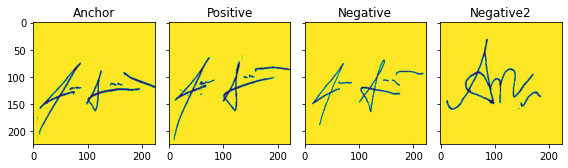

In [8]:
data_shapes(dataset)       # seeing dataset
plot_quadruplets(dataset)  # plotting dataset

In [9]:
# Hyper parameters
alpha1 = 1
alpha2 = 0.5
embeddingsize = 10
nb_test_class = 10

evaluate_every = 1000 # interval for evaluating on one-shot tasks
n_iter = 10000        # No. of training iterations
log_every = 100
batch_size = 32

optimizer = Adam(lr = 0.00006)

In [10]:
projectName = "CEDAR_quadruplet_loss"

# wandb config
wandb.init(project=projectName)
wandb.config.alpha1 = alpha1
wandb.config.alpha2 = alpha2
wandb.config.batch_size = batch_size
wandb.config.learningrate = K.eval(optimizer.lr)

wandb: Currently logged in as: ikathuria (use `wandb login --relogin` to force relogin)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
negative2_input (InputLayer)    [(None, 224, 224, 1) 0                                            
______________________________________________________________________________________________

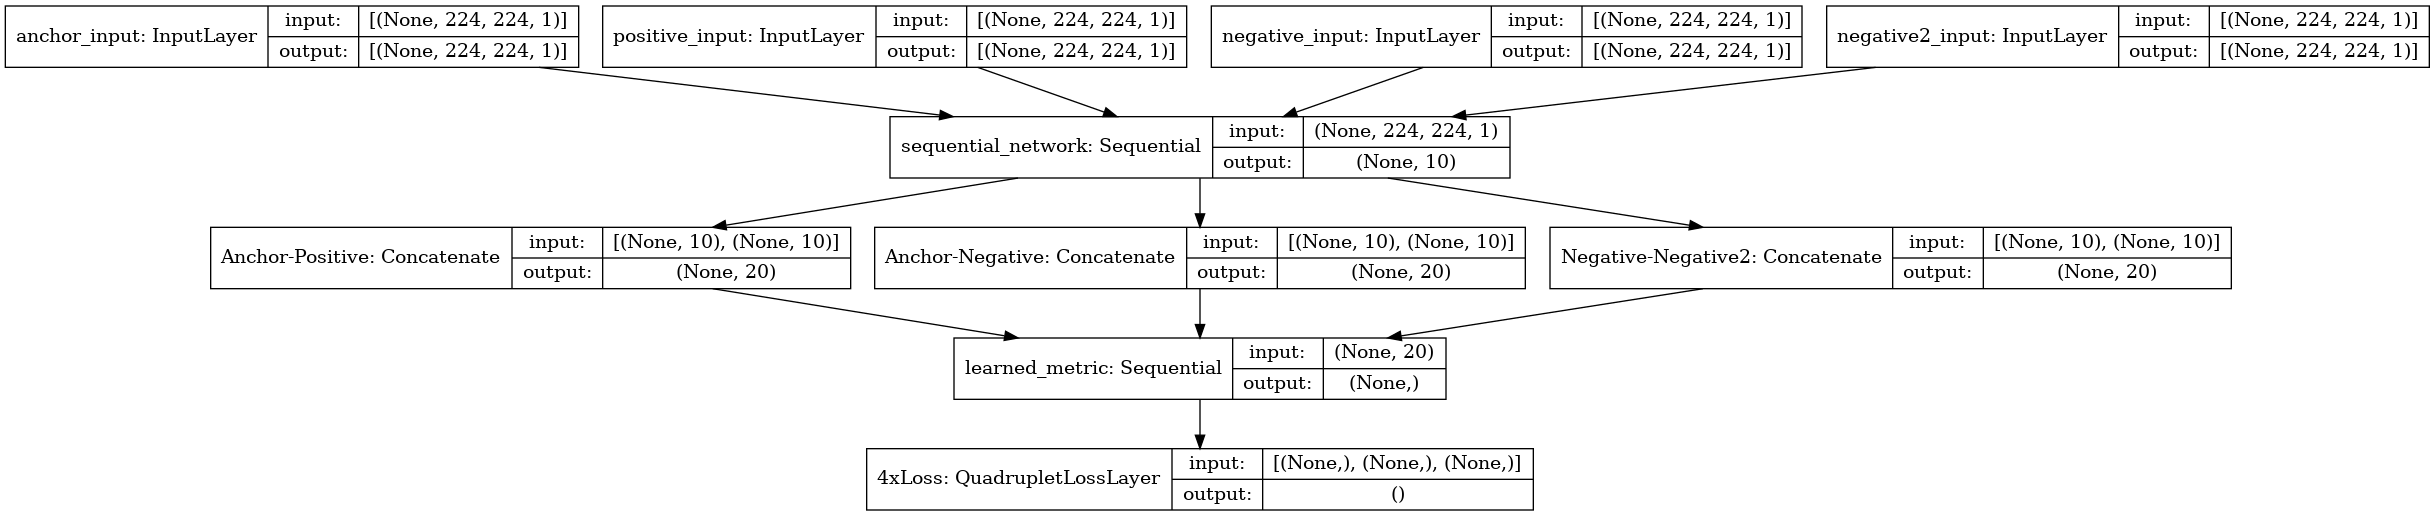

In [11]:
with tpu_strategy.scope():
    # defining the embedding and network
    embedding = embedding_net(embeddingsize, INPUT_SHAPE)
    metric_network = build_metric_network(single_embedding_shape=[embeddingsize])
    siamese_network4 = build_quadruplet_model(INPUT_SHAPE, embedding, metric_network, margin=alpha1, margin2=alpha2)
    siamese_network4.compile(loss=None, optimizer=optimizer)

siamese_network4.summary()
plot_model(siamese_network4, show_shapes=True, show_layer_names=True, to_file='QUADRUPLETmodel.png')

In [12]:
n_iteration = 0
print("Starting training process!")
print("-------------------------------------")

t_start = time.time()
for i in range(1, n_iter+1):
    microtask_start = time.time()
    quadruplets = dataset.generate_quadruplet(batch_size)
    timetogetbatch = time.time()-microtask_start

    microtask_start = time.time()
    loss = siamese_network4.train_on_batch(quadruplets, None)
    timebatch3 = time.time()-microtask_start

    microtask_start = time.time()

    n_iteration += 1

    if i % log_every == 0:
        wandb.log({'loss4x': loss}, step=n_iteration)

    if i % evaluate_every == 0:
        elapsed_minutes = (time.time()-t_start)/60.0
        rate = i/elapsed_minutes
        eta = datetime.now() + timedelta(minutes=(n_iter-i)/rate)

        print("[{3}] iteration {0}: {1:.1f} iter/min, Train Loss: {2} , eta : {4}".format(
            i, rate, loss, n_iteration, eta.strftime("%Y-%m-%d %H:%M:%S")
        ))

        siamese_network4.save_weights('./weights/4x-temp_weights_{0:08d}.h5'.format(n_iteration))

# Final save
siamese_network4.save_weights('./weights/4x-temp_weights_{0:08d}.h5'.format(n_iteration))
print("Done !")

Starting training process!
-------------------------------------
[1000] iteration 1000: 61.0 iter/min, Train Loss: 0.8717893362045288 , eta : 2021-07-15 12:10:11
[2000] iteration 2000: 60.7 iter/min, Train Loss: 0.38104820251464844 , eta : 2021-07-15 12:10:56
[3000] iteration 3000: 60.6 iter/min, Train Loss: 0.41087016463279724 , eta : 2021-07-15 12:11:11
[4000] iteration 4000: 60.3 iter/min, Train Loss: 0.25949808955192566 , eta : 2021-07-15 12:12:07
[5000] iteration 5000: 60.0 iter/min, Train Loss: 0.20413880050182343 , eta : 2021-07-15 12:12:54
[6000] iteration 6000: 60.1 iter/min, Train Loss: 0.24317586421966553 , eta : 2021-07-15 12:12:34
[7000] iteration 7000: 60.2 iter/min, Train Loss: 0.19652338325977325 , eta : 2021-07-15 12:12:18
[8000] iteration 8000: 60.3 iter/min, Train Loss: 0.2204257845878601 , eta : 2021-07-15 12:12:12
[9000] iteration 9000: 60.3 iter/min, Train Loss: 0.17935867607593536 , eta : 2021-07-15 12:12:03
[10000] iteration 10000: 60.3 iter/min, Train Loss: 0.1

In [13]:
!zip -r './weights.zip' './weights/4x-temp_weights_00010000.h5'

updating: weights/4x-temp_weights_00010000.h5
zip I/O error: No space left on device
zip error: Output file write failure (write error on zip file)
